# **QPSK BER Kurve mit Mapping und SNR**

### QPSK-Modulation in Schritten erklärt:

1. Iteration über die Binärdaten: Die Binärdaten werden in zweier Blöcke von Bits geteilt.
2. String-Umwandlung: Die zwei Bits werden zu einem String zusammengefasst, der eine binäre Zahl repräsentiert.
3. Index-Berechnung: Der String wird als binäre Zahl interpretiert und in einen Integer umgewandelt. Dieser Integer dient als Index für das Array "symbole".
4. Symbol-Auswahl: Das entsprechende QPSK-Symbol wird aus dem Array "symbole" ausgewählt und zur Liste daten_symbole hinzugefügt.
5. Array-Konvertierung: Die Liste der Symbole wird in ein NumPy Array umgewandelt und zurückgegeben.


*Hinweis:* Der Code rechnet aktuell mit SNR und das Diagramm wird auch dementsprechend erzeugt. Bei Eb/N0 machen die Werte noch keinen Sinn.

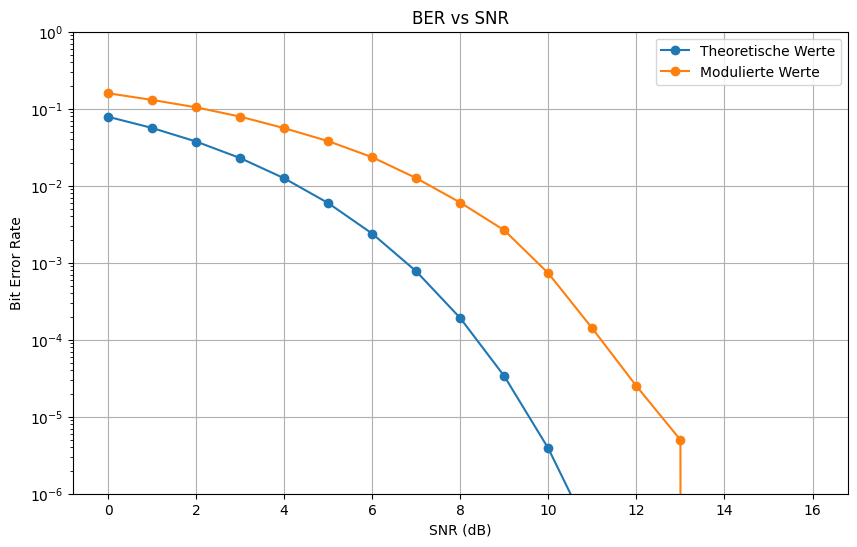

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.special import erfc

def ber_qpsk(snr_db):
    snr_lin = 10**(snr_db / 10.0)
    ber_theo = 0.5 * erfc(np.sqrt(snr_lin))
    return ber_theo

def qpsk_modulation(data):
    # QPSK Symbole mit Gray-Codierung:
    # 00 -> 1+0j (0°) || 01 -> 0+1j (90°) || 11 -> -1+0j (180°) || 10 -> 0-1j (270°)
    symbole = np.array([1+0j, 0+1j, 0-1j, -1+0j])

    # Initialisiert eine leere Liste für die modulierten Daten
    data_mod = []

    # Geht durch die binären Daten in Schritten von zwei Bits
    for i in range(0, len(data), 2):
        # Wandelt das Bitpaar in einen String um
        # Nimmt die nächsten zwei Binärdaten aus der Liste
        bit_list = data[i:i+2]
        # Konvertiert jede Binärzahl in einen String
        bit_str_list = [str(bit) for bit in bit_list]
        # Fügt die Strings zu einem einzigen String zusammen
        bitpaar_str = ''.join(bit_str_list)

        # Wandelt den String in einen Integer um (basierend auf Binär)
        #print("bitpaar: ", bitpaar_str)
        index = int(bitpaar_str, 2)
        #print("index:", index)

        # Wählt das entsprechende Symbol aus und fügt es der Liste hinzu
        symbol = symbole[index]
        #print("symbol: ", symbol)
        data_mod.append(symbol)

    # Konvertiert die Liste von Symbolen in ein NumPy Array und gib es zurück
    return np.array(data_mod)

def qpsk_demodulation(daten):
    data_demod = []
    for d in daten:
        # arctan2 -> -180° bis 180°
        winkel = np.arctan2(np.imag(d), np.real(d))
        # Bestimmt das Bitpaar basierend auf dem Winkel des Symbols
        if -np.pi/4 < winkel <= np.pi/4:
            data_demod.extend([0, 0])  # 1. Quadrant: 00
        elif np.pi/4 < winkel <= 3*np.pi/4:
            data_demod.extend([0, 1])  # 2. Quadrant: 01
        elif -3*np.pi/4 < winkel <= -np.pi/4:
            data_demod.extend([1, 0])  # 4. Quadrant: 10
        else:
            data_demod.extend([1, 1])  # 3. Quadrant: 11
    return np.array(data_demod)

def awgn_kanal(daten, snr_db):
    # SNR in linear
    snr = 10**(snr_db/10)
    signal = np.mean(np.abs(daten)**2)
    rauschleistung = signal / snr
    rauschen = np.sqrt(rauschleistung / 2) * (np.random.randn(*daten.shape) + 1j * np.random.randn(*daten.shape))
    empf_daten = daten + rauschen
    return empf_daten

# Bereich von SNR Werten 0-17
snr_range = np.arange(0, 17, 1)

# 2 Bits pro Symbol
N = 100000  # Anzahl der Symbole
data = np.random.randint(0, 2, 2*N)   # bits oder data ? bits oder Sybole ?

ber = []
ber_theo_werte = []

for snr_db in snr_range:
  #Theoretische BER-Kurve
  ber_theo = ber_qpsk(snr_db)
  ber_theo_werte.append(ber_theo)

  # Modulation
  qpsk_symbole = qpsk_modulation(data)

  # AWGN Rauschen hinzufügen
  qpsk_symbole_rauschen = awgn_kanal(qpsk_symbole, snr_db)

  # Demodulation
  data_demod = qpsk_demodulation(qpsk_symbole_rauschen)

  # Fehler berechnen
  fehler = np.sum(data[:len(data_demod)] != data_demod)

  # Anzahl Fehler durch die Menge der gesendeten Bits teilen
  ber.append(fehler / len(data_demod))



plt.figure(figsize=(10, 6))
plt.semilogy(ber_theo_werte, 'o-', label='Theoretische Werte')
plt.semilogy(snr_range, ber, 'o-', label='Modulierte Werte')
plt.title('BER vs SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate')
plt.ylim([1e-6, 1])  # Y-Achsen-Begrenzung
plt.grid(True)
plt.legend()
plt.show()